In [1]:
# %matplotlib inline
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from mpdaf.sdetect import Source
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
import astropy.coordinates.distances as Distance
import matplotlib as mp
import cmasher as cmr
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian1DKernel, convolve

from mpdaf.obj import Cube, Spectrum, WaveCoord, iter_spe
from mpdaf.drs import PixTable
from mpdaf.sdetect import Source, compute_optimal_spectrum
import string as s

from astrodendro import Dendrogram

import glob
pd.set_option('chained_assignment',None)
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)


pd.set_option('chained_assignment',None)

from matplotlib import rc
rc('font',**{'family':'sans','serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [2]:
from mpdaf.obj import Cube, Spectrum, WaveCoord, iter_spe
from mpdaf.drs import PixTable
from mpdaf.sdetect import Source, compute_optimal_spectrum



In [3]:
galaxies = glob.glob('../outputs/jasper_1206_LAEs/MAGPI1206_source_*.fits')

[DEBUG] Doing LA
[DEBUG] Image LA has one useful objects
[WARNING] The world coordinates and data have different dimensions. Modifying the shape of the WCS object
[DEBUG] Doing LA
[DEBUG] Image LA has one useful objects
[WARNING] The world coordinates and data have different dimensions. Modifying the shape of the WCS object


../outputs/jasper_1206_LAEs/MAGPI1206_source_198.fits


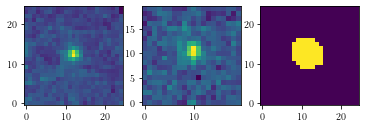

In [4]:
for galaxy in galaxies: 

    s = Source.from_file(galaxy)
    
    
    s.add_seg_images(tags=[ 'LA'])

    s.find_sky_mask(seg_tags=[ 'LA'])

    s.find_union_mask(seg_tags=['LA'])

    s.find_intersection_mask(seg_tags=[ 'LA'])

    s.write(galaxy.replace('source', 'updated_source'))

    print(galaxy)
    
    fig, axs = plt.subplots(ncols=3)

    s.images['MUSE_WHITE'].plot(ax=axs[0])
    s.images['LA'].plot(ax=axs[1])
    s.images['SEG_LA'].plot(ax=axs[2])
    
    break 


In [29]:


r = radial_data(s.images['LA'].data ,annulus_width=1,working_mask=None,x=None,y=None,rmax=None)

In [31]:
len(r.r)

15

In [28]:
np.sqrt(50)

7.0710678118654755

In [17]:
npix = 50.
x = np.arange(npix) - npix/2.
xx, yy = np.meshgrid(x, x)
r = np.sqrt(xx**2 + yy**2)
fake_psf = np.exp(-(r/5.)**2)
noise = 0.1 * np.random.normal(0, 1, r.size).reshape(r.shape)
simulation = fake_psf + noise

rad_stats = radial_data(simulation, x=xx, y=yy)

In [19]:
rad_stats.r

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
       22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
       33.5, 34.5, 35.5])

In [21]:
simulation.shape

(50, 50)

In [24]:
x+1j

array([-25.+1.j, -24.+1.j, -23.+1.j, -22.+1.j, -21.+1.j, -20.+1.j,
       -19.+1.j, -18.+1.j, -17.+1.j, -16.+1.j, -15.+1.j, -14.+1.j,
       -13.+1.j, -12.+1.j, -11.+1.j, -10.+1.j,  -9.+1.j,  -8.+1.j,
        -7.+1.j,  -6.+1.j,  -5.+1.j,  -4.+1.j,  -3.+1.j,  -2.+1.j,
        -1.+1.j,   0.+1.j,   1.+1.j,   2.+1.j,   3.+1.j,   4.+1.j,
         5.+1.j,   6.+1.j,   7.+1.j,   8.+1.j,   9.+1.j,  10.+1.j,
        11.+1.j,  12.+1.j,  13.+1.j,  14.+1.j,  15.+1.j,  16.+1.j,
        17.+1.j,  18.+1.j,  19.+1.j,  20.+1.j,  21.+1.j,  22.+1.j,
        23.+1.j,  24.+1.j])

In [10]:
def radial_data(data,annulus_width=1,working_mask=None,x=None,y=None,rmax=None):
    """
    r = radial_data(data,annulus_width,working_mask,x,y)
    
    A function to reduce an image to a radial cross-section.
    
    :INPUT:
      data   - whatever data you are radially averaging.  Data is
              binned into a series of annuli of width 'annulus_width'
              pixels.

      annulus_width - width of each annulus.  Default is 1.

      working_mask - array of same size as 'data', with zeros at
                        whichever 'data' points you don't want included
                        in the radial data computations.

      x,y - coordinate system in which the data exists (used to set
               the center of the data).  By default, these are set to
               integer meshgrids

      rmax -- maximum radial value over which to compute statistics
    
    :OUTPUT:
        r - a data structure containing the following
                   statistics, computed across each annulus:

          .r      - the radial coordinate used (outer edge of annulus)

          .mean   - mean of the data in the annulus

          .sum    - the sum of all enclosed values at the given radius

          .std    - standard deviation of the data in the annulus

          .median - median value in the annulus

          .max    - maximum value in the annulus

          .min    - minimum value in the annulus

          .numel  - number of elements in the annulus

    :EXAMPLE:        
      ::
        
        import numpy as np
        import pylab as py
        import radial_data as rad

        # Create coordinate grid
        npix = 50.
        x = np.arange(npix) - npix/2.
        xx, yy = np.meshgrid(x, x)
        r = np.sqrt(xx**2 + yy**2)
        fake_psf = np.exp(-(r/5.)**2)
        noise = 0.1 * np.random.normal(0, 1, r.size).reshape(r.shape)
        simulation = fake_psf + noise

        rad_stats = rad.radial_data(simulation, x=xx, y=yy)

        py.figure()
        py.plot(rad_stats.r, rad_stats.mean / rad_stats.std)
        py.xlabel('Radial coordinate')
        py.ylabel('Signal to Noise')
    """
    
# 2012-02-25 20:40 IJMC: Empty bins now have numel=0, not nan.
# 2012-02-04 17:41 IJMC: Added "SUM" flag
# 2010-11-19 16:36 IJC: Updated documentation for Sphinx
# 2010-03-10 19:22 IJC: Ported to python from Matlab
# 2005/12/19 Added 'working_region' option (IJC)
# 2005/12/15 Switched order of outputs (IJC)
# 2005/12/12 IJC: Removed decifact, changed name, wrote comments.
# 2005/11/04 by Ian Crossfield at the Jet Propulsion Laboratory
 
    import numpy as ny

    class radialDat:
        """Empty object container.
        """
        def __init__(self): 
            self.mean = None
            self.std = None
            self.median = None
            self.numel = None
            self.max = None
            self.min = None
            self.r = None

    #---------------------
    # Set up input parameters
    #---------------------
    data = ny.array(data)
    
    if working_mask==None:
        working_mask = ny.ones(data.shape,bool)
    
    npix, npiy = data.shape
    if x is None or y is None:
        x1 = ny.arange(-npix/2.,npix/2.)
        y1 = ny.arange(-npiy/2.,npiy/2.)
        x,y = ny.meshgrid(y1,x1)

    r = abs(x+1j*y)

    if rmax==None:
        rmax = r[working_mask].max()

    #---------------------
    # Prepare the data container
    #---------------------
    dr = ny.abs([x[0,0] - x[0,1]]) * annulus_width
    radial = ny.arange(rmax/dr)*dr + dr/2.
    nrad = len(radial)
    radialdata = radialDat()
    radialdata.mean = ny.zeros(nrad)
    radialdata.sum = ny.zeros(nrad)
    radialdata.std = ny.zeros(nrad)
    radialdata.median = ny.zeros(nrad)
    radialdata.numel = ny.zeros(nrad, dtype=int)
    radialdata.max = ny.zeros(nrad)
    radialdata.min = ny.zeros(nrad)
    radialdata.r = radial
    
    #---------------------
    # Loop through the bins
    #---------------------
    for irad in range(nrad): #= 1:numel(radial)
      minrad = irad*dr
      maxrad = minrad + dr
      thisindex = (r>=minrad) * (r<maxrad) * working_mask
      #import pylab as py
      #pdb.set_trace()
      if not thisindex.ravel().any():
        radialdata.mean[irad] = ny.nan
        radialdata.sum[irad] = ny.nan
        radialdata.std[irad]  = ny.nan
        radialdata.median[irad] = ny.nan
        radialdata.numel[irad] = 0
        radialdata.max[irad] = ny.nan
        radialdata.min[irad] = ny.nan
      else:
        radialdata.mean[irad] = data[thisindex].mean()
        radialdata.sum[irad] = data[r<maxrad].sum()
        radialdata.std[irad]  = data[thisindex].std()
        radialdata.median[irad] = ny.median(data[thisindex])
        radialdata.numel[irad] = data[thisindex].size
        radialdata.max[irad] = data[thisindex].max()
        radialdata.min[irad] = data[thisindex].min()
    
    #---------------------
    # Return with data
    #---------------------
    
    return radialdata

In [26]:
np.sqrt(10**2 + 10**2)

14.142135623730951

In [19]:
galaxies[0].replace('source', 'updated_source')

'../outputs/jasper_1206_LAEs/MAGPI1206_updated_source_198.fits'

../outputs/jasper_1206_LAEs/MAGPI1206_updated_source_73.fits
../outputs/jasper_1206_LAEs/MAGPI1206_updated_source_190.fits
../outputs/jasper_1206_LAEs/MAGPI1206_updated_source_43.fits
../outputs/jasper_1206_LAEs/MAGPI1206_updated_source_191.fits
../outputs/jasper_1206_LAEs/MAGPI1206_updated_source_200.fits
../outputs/jasper_1206_LAEs/MAGPI1206_updated_source_74.fits
../outputs/jasper_1206_LAEs/MAGPI1206_updated_source_192.fits
../outputs/jasper_1206_LAEs/MAGPI1206_updated_source_131.fits
../outputs/jasper_1206_LAEs/MAGPI1206_updated_source_76.fits
../outputs/jasper_1206_LAEs/MAGPI1206_updated_source_198.fits
../outputs/jasper_1206_LAEs/MAGPI1206_updated_source_92.fits
../outputs/jasper_1206_LAEs/MAGPI1206_updated_source_141.fits
../outputs/jasper_1206_LAEs/MAGPI1206_updated_source_101.fits


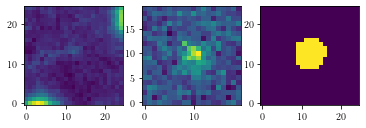

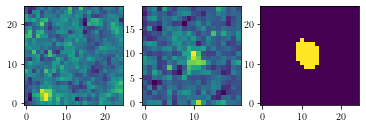

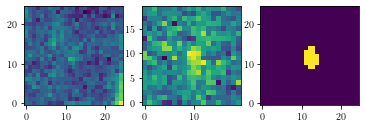

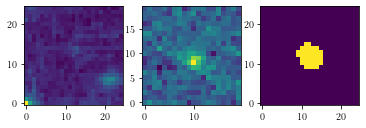

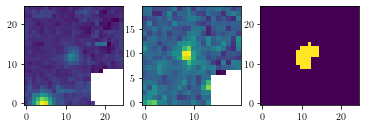

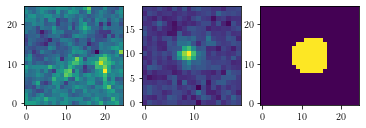

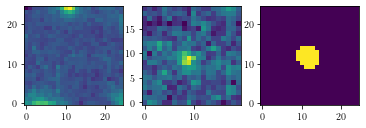

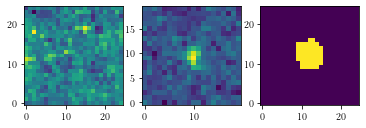

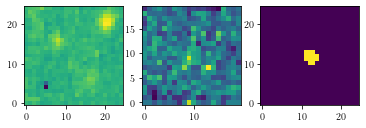

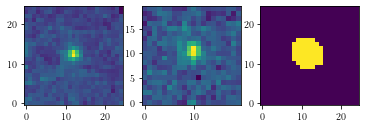

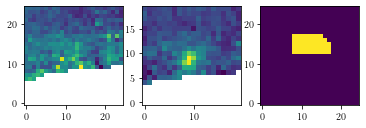

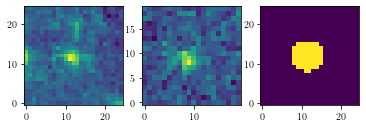

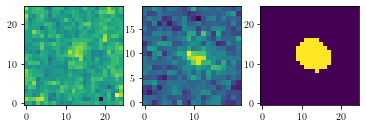

In [5]:
galaxies = glob.glob('../outputs/jasper_1206_LAEs/MAGPI1206_updated_source_*.fits')

for galaxy in galaxies: 

    s = Source.from_file(galaxy)
    
    print(galaxy)
    
    fig, axs = plt.subplots(ncols=3)

    s.images['MUSE_WHITE'].plot(ax=axs[0])
    s.images['LA'].plot(ax=axs[1])
    s.images['SEG_LA'].plot(ax=axs[2])


In [14]:
s.extract_spectra(s.cubes['MUSE'],obj_mask='SEG_LA', tags_to_try=['LA'])

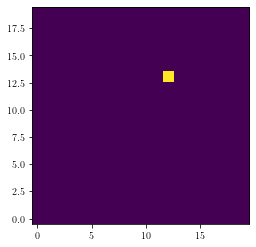

In [17]:
s.images['MASK_UNION'].plot()

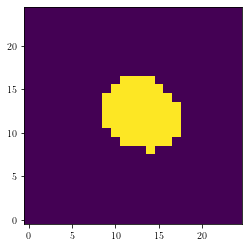

In [22]:
s.images['SEG_LA'].plot()

In [15]:
s.info()

[INFO] ID      =                  101 / object ID %d                                   
[INFO] RA      =     180.167259923912 / RA u.degree %.7f                               
[INFO] DEC     =   -1.447188327073357 / DEC u.degree %.7f                              
[INFO] FROM    = 'test    '           / detection software                             
[INFO] FROM_V  = 'v0.0    '           / version of the detection software              
[INFO] CUBE    = 'MAGPI1206.fits'     / datacube                                       
[INFO] CUBE_V  = 'v1.34   '           / version of the datacube                        
[INFO] SRC_V   = ''                                                                    
[INFO] Y       =    283.0000000001016                                                  
[INFO] X       =    100.9999999998212                                                  
[INFO] FORMAT  = '0.6     '           / Version of the Source format                   
[INFO] 2 spectra: MUSE_SKY MUSE_

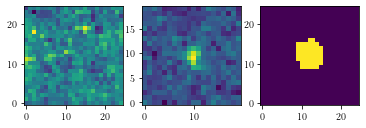

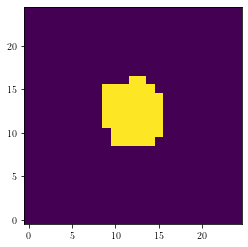